Author: Elizabeth Luong

Date: 19 March 2025

## Q1

**Dataset Source:** The dataset was originally obtained from Kaggle and manually uploaded to JupyterHub instead of using the Kaggle API.

Citation: Khashayar Baghizadeh, ["Titanic"](https://www.kaggle.com/datasets/heptapod/titanic)

Columns in dataset: Index(['Passengerid', 'Age', 'Fare', 'Sex', 'sibsp', 'zero', 'zero.1',
       'zero.2', 'zero.3', 'zero.4', 'zero.5', 'zero.6', 'Parch', 'zero.7',
       'zero.8', 'zero.9', 'zero.10', 'zero.11', 'zero.12', 'zero.13',
       'zero.14', 'Pclass', 'zero.15', 'zero.16', 'Embarked', 'zero.17',
       'zero.18', 'Survived'],
      dtype='object')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.


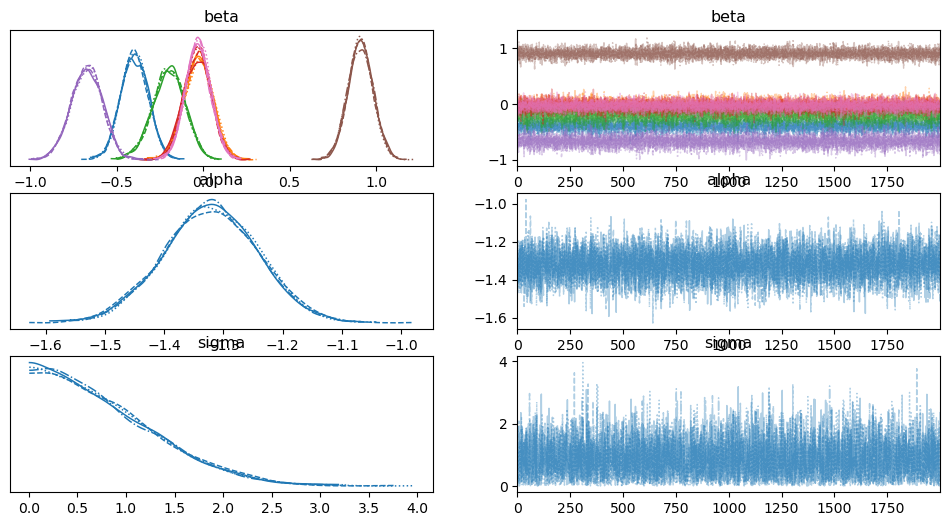

In [4]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the dataset
df = pd.read_csv("train_and_test2.csv")

# Rename incorrectly formatted columns
df = df.rename(columns={'2urvived': 'Survived'})

# Print actual column names
print("Columns in dataset:", df.columns)

# Select relevant features (ignoring 'Passengerid' and unnamed 'zero' columns)
numeric_features = ['Age', 'Fare', 'sibsp', 'Parch', 'Pclass']  # Select actual numeric features
categorical_features = ['Sex', 'Embarked']

# Handle missing values
df[numeric_features] = df[numeric_features].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=numeric_features)  # Drop missing numeric values

# Encode categorical variables
for col in categorical_features:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Define predictors and target
X_columns = numeric_features + categorical_features
y_column = 'Survived'

# Standardize features
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(df[X_columns])
y_scaled = scaler_y.fit_transform(df[[y_column]]).flatten()

# Define Bayesian model
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, sigma=1, shape=len(X_columns))
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = alpha + pm.math.dot(X_scaled, beta)
    y_obs = pm.Bernoulli("y_obs", logit_p=mu, observed=y_scaled)

    # Sampling with higher target_accept for stability
    trace = pm.sample(2000, return_inferencedata=True, target_accept=0.95)

# Summary
az.summary(trace, var_names=["beta", "alpha", "sigma"])

# Plot posterior distributions
az.plot_trace(trace, var_names=["beta", "alpha", "sigma"])
plt.show()


## Q2


X shape: (1307, 8), y shape: (1307,)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 67 seconds.


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    0.000  0.024  -0.043    0.047        0.0      0.0   12458.0   
beta[0] -0.145  0.027  -0.196   -0.093        0.0      0.0   11095.0   
beta[1]  0.004  0.032  -0.058    0.061        0.0      0.0   10018.0   
beta[2] -0.061  0.027  -0.111   -0.011        0.0      0.0   13175.0   
beta[3] -0.015  0.028  -0.068    0.036        0.0      0.0   11791.0   
beta[4] -0.242  0.032  -0.305   -0.184        0.0      0.0    9809.0   
beta[5] -0.006  0.030  -0.062    0.051        0.0      0.0   10225.0   
beta[6] -0.017  0.030  -0.071    0.042        0.0      0.0   10218.0   
beta[7]  0.372  0.026   0.321    0.419        0.0      0.0   11891.0   
sigma    0.888  0.017   0.855    0.921        0.0      0.0   11541.0   

         ess_tail  r_hat  
alpha      6154.0    1.0  
beta[0]    6142.0    1.0  
beta[1]    6181.0    1.0  
beta[2]    6803.0    1.0  
beta[3]    6523.0    1.0  
beta[4]    6434.0    1.0  
beta[5]    6110.0 

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

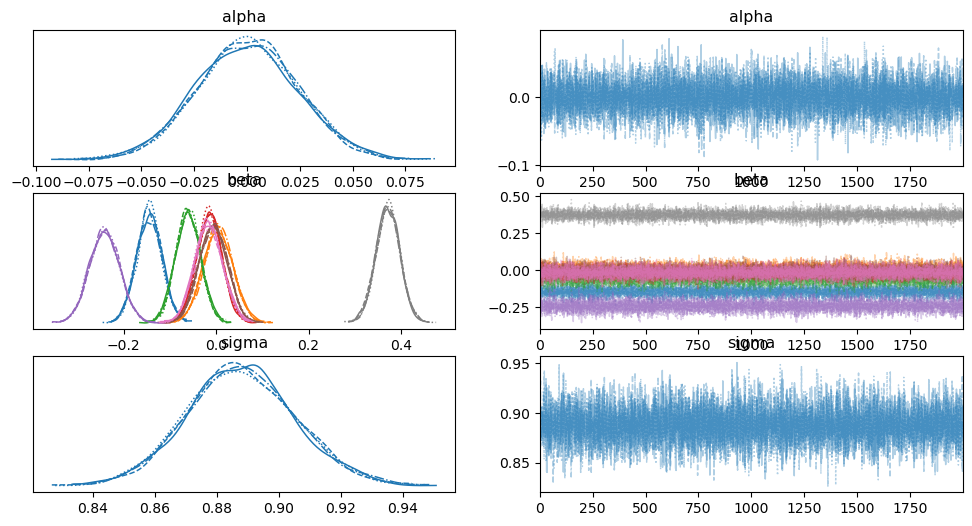

In [13]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load dataset (Ensure you use the correct file path)
df = pd.read_csv("train_and_test2.csv")

# Rename any misread columns
df = df.rename(columns={'2urvived': 'Survived'})  

# Define Feature and Target Columns
X_columns = ['Age', 'Fare', 'sibsp', 'Parch', 'Pclass']  # Exclude 'Sex' and 'Embarked' for now
categorical_columns = ['Sex', 'Embarked']  # Categorical columns

# Drop NaNs in relevant columns
df_clean = df.dropna(subset=X_columns + categorical_columns + ['Survived'])

# Convert categorical variables to numerical (One-Hot Encoding)
df_clean = pd.get_dummies(df_clean, columns=categorical_columns, drop_first=True)

# Append newly created columns from encoding
X_columns += list(df_clean.columns.difference(df.columns))  # Automatically add new dummies

# Standardize numerical columns
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(df_clean[X_columns])
y_scaled = scaler_y.fit_transform(df_clean[['Survived']]).flatten()

# Print to verify correct shape
print(f"X shape: {X_scaled.shape}, y shape: {y_scaled.shape}")

# Define Bayesian Model
with pm.Model() as model:
    # Priors for regression coefficients
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape=len(X_columns))
    
    # Noise term
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Linear model
    mu = alpha + pm.math.dot(X_scaled, beta)

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_scaled)

    # Sample from posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# Summarize results
summary = az.summary(trace)
print(summary)

# Plot Posterior Distributions
az.plot_trace(trace, var_names=["alpha", "beta", "sigma"])


## Q3

X shape: (1309, 5), y shape: (1309,)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    0.000  0.026  -0.052    0.046        0.0      0.0    9277.0   
beta[0] -0.175  0.029  -0.231   -0.121        0.0      0.0    9094.0   
beta[1]  0.045  0.034  -0.017    0.109        0.0      0.0    7889.0   
beta[2] -0.055  0.030  -0.109    0.002        0.0      0.0    9284.0   
beta[3]  0.049  0.029  -0.007    0.103        0.0      0.0    8922.0   
beta[4] -0.284  0.035  -0.345   -0.217        0.0      0.0    7805.0   
sigma    0.956  0.019   0.921    0.992        0.0      0.0    9787.0   

         ess_tail  r_hat  
alpha      6224.0    1.0  
beta[0]    6210.0    1.0  
beta[1]    6517.0    1.0  
beta[2]    6421.0    1.0  
beta[3]    6517.0    1.0  
beta[4]    5930.0    1.0  
sigma      6041.0    1.0  


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>],
       [<Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n3'}>,
        <Axes: title={'center': 'beta\n4'}>],
       [<Axes: title={'center': 'sigma'}>, <Axes: >, <Axes: >]],
      dtype=object)

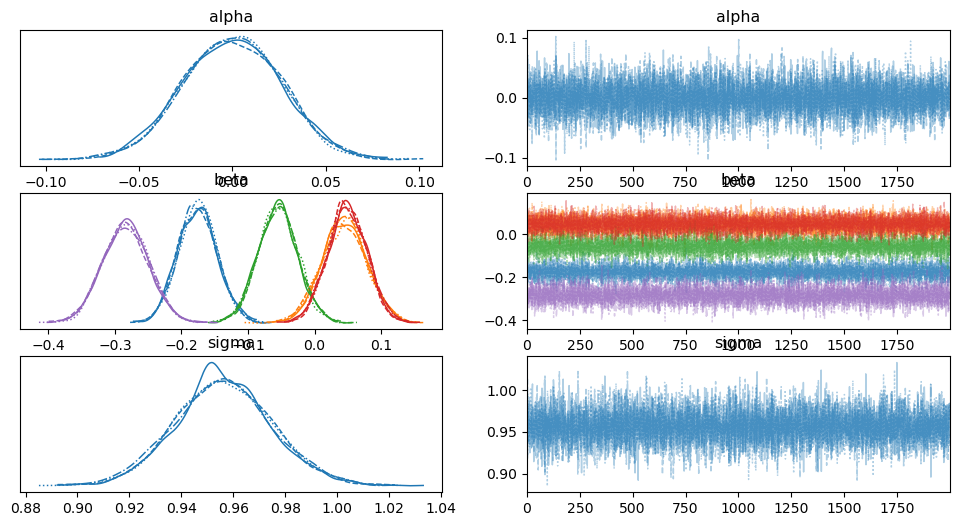

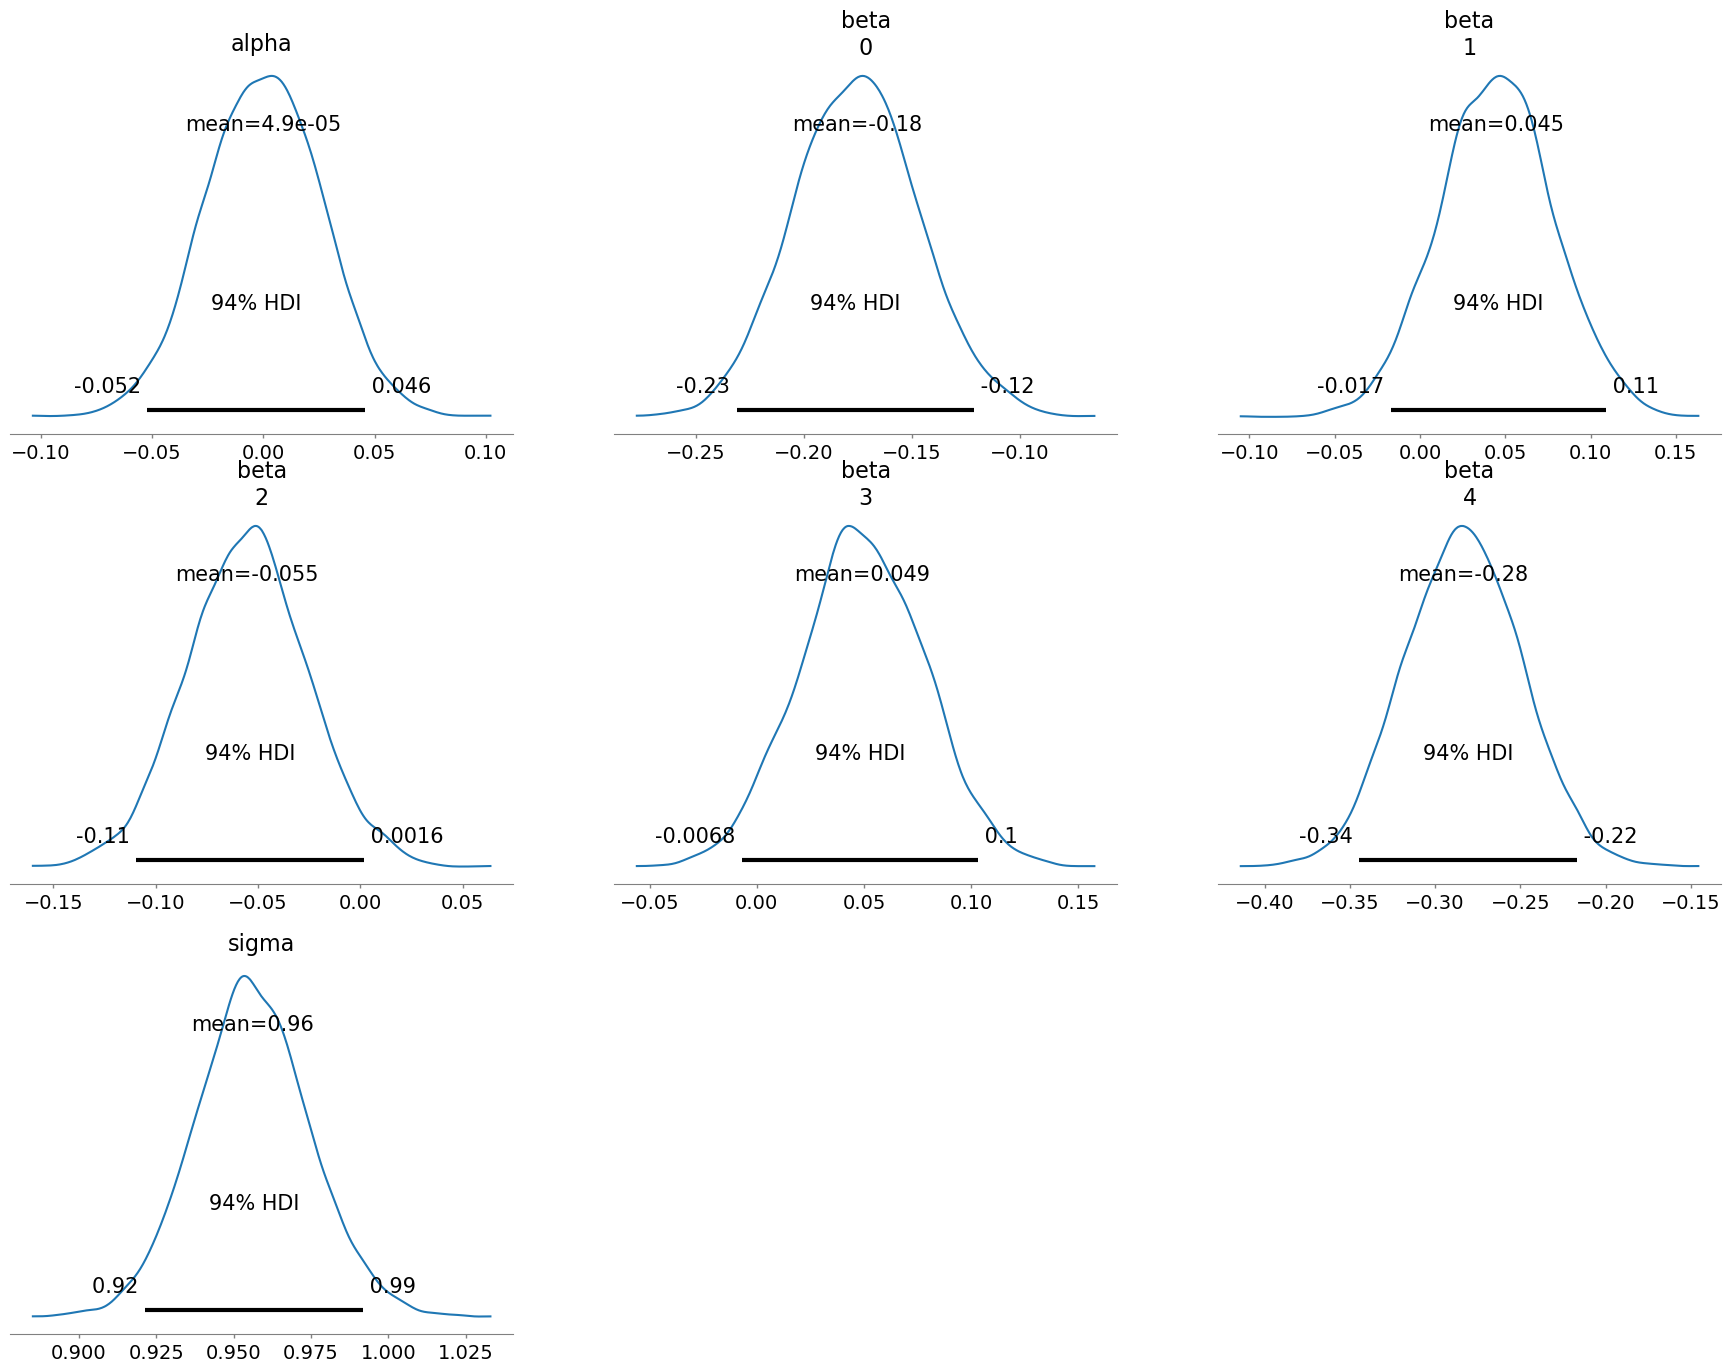

In [18]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load dataset (Ensure you use the correct file path)
df = pd.read_csv("train_and_test2.csv")

# Selecting relevant features based on preprocessing in Q2
X_columns = ['Age', 'Fare', 'sibsp', 'Parch', 'Pclass']  # Adjust feature names if necessary
y_column = '2urvived'  # Ensure this is the correct target variable name

# Drop NaNs synchronously in both X and y
df_clean = df.dropna(subset=[y_column] + X_columns)

# Standardize predictors and target variable
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(df_clean[X_columns])
y_scaled = scaler_y.fit_transform(df_clean[[y_column]]).flatten()

# Print shape to verify preprocessing
print(f"X shape: {X_scaled.shape}, y shape: {y_scaled.shape}")

# Define Bayesian Model
with pm.Model() as model:
    # Priors for regression coefficients
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape=len(X_columns))
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value (linear model)
    mu = alpha + pm.math.dot(X_scaled, beta)

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_scaled)

    # Perform sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# Summarize the posterior distributions
summary = az.summary(trace)
print(summary)

# Plot posterior distributions
az.plot_trace(trace)
az.plot_posterior(trace)
